In [1]:
import pickle
import urllib
from matplotlib import pyplot as plt
import matplotlib

import numpy as np
import torch
import torchvision
from imagenetv2_pytorch import ImageNetV2Dataset

import utils.metrics
import utils.model

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

Using device: cuda

GeForce RTX 2070 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
transforms_normalized = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset = ImageNetV2Dataset(
    transform=transforms_normalized, location="imagenet")
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=64,
                                          shuffle=False)

In [4]:
class_names = pickle.load(urllib.request.urlopen(
    'https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))

In [5]:
# mobilenet_small = torchvision.models.mobilenet.mobilenet_v3_small(
#     pretrained=True)

mobilenet_large = torchvision.models.mobilenet.mobilenet_v3_large(
    pretrained=True)

# vgg11_bn = torchvision.models.vgg11_bn(pretrained=True, progress=False)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /home/jirka/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

In [6]:
progress = utils.model.run_validation(
    mobilenet_large, data_loader, utils.metrics.Progress(), device, use_mc_dropout=True)

Avg. acc.: 0.60: 100%|██████████| 157/157 [03:48<00:00,  1.45s/it]


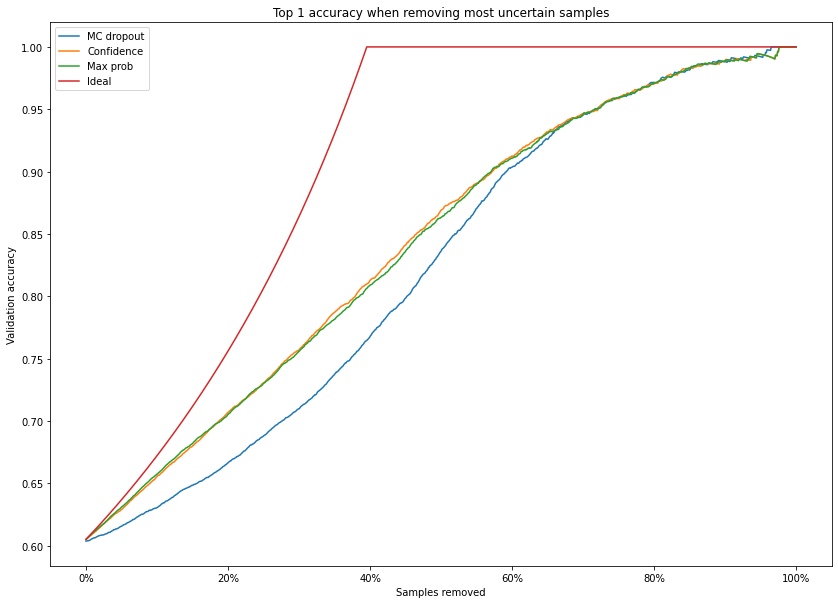

In [53]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(1, 1, 1)
for label, idx in [("MC dropout", np.argsort(progress.dropout_variances)[::-1]),
                   ("Confidence", np.argsort(progress.confidences)),
                   ("Max prob", np.argsort(progress.max_probs)),
                   ("Ideal", np.argsort(progress.predictions == progress.labels))]:
    labels = progress.labels[idx]
    predictions = progress.dropout_predictions[
        idx] if label == "MC dropout" else progress.predictions[idx]
    accs = utils.metrics.roc_stat(labels, predictions, step=10)
    x = np.linspace(0, 100, len(accs))
    ax.plot(x, accs, label=label)
ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())
ax.set_xlabel("Samples removed")
ax.set_ylabel("Validation accuracy")
ax.set_title("Top 1 accuracy when removing most uncertain samples")
ax.legend()

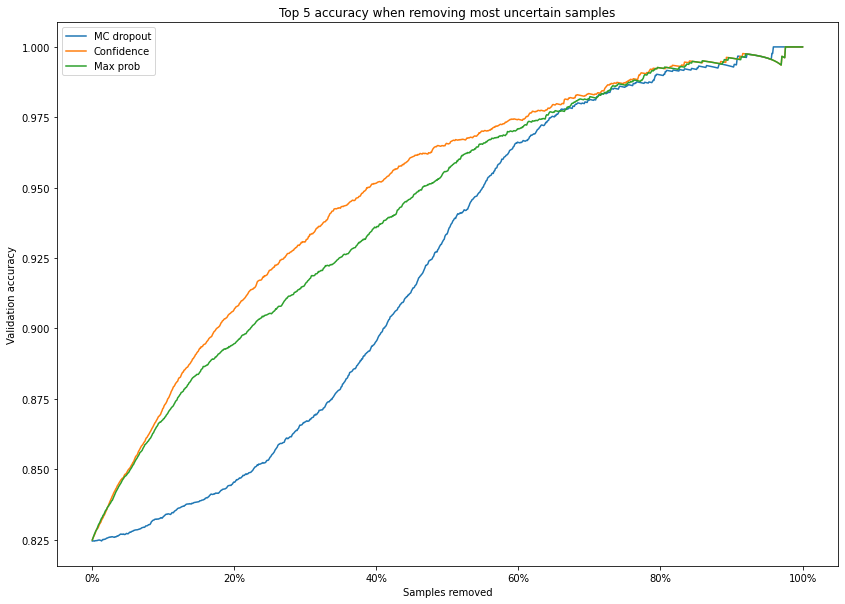

In [54]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(1, 1, 1)
for label, idx in [("MC dropout", np.argsort(progress.dropout_variances)[::-1]),
                   ("Confidence", np.argsort(progress.confidences)),
                   ("Max prob", np.argsort(progress.max_probs))]:
    labels = progress.labels[idx]
    outputs = progress.dropout_outputs if label == "MC dropout" else progress.probs
    top5preds = outputs.argsort(axis=1)[:, :-6:-1][idx]
    accs = []
    correct = [label in preds for label, preds in zip(
        labels, top5preds)]
    for _ in range(len(labels)//10):
        accs.append(sum(correct)/len(correct))
        correct = correct[10:]
    ax.plot(np.linspace(0, 100, len(accs)), accs, label=label)
ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())
ax.set_xlabel("Samples removed")
ax.set_ylabel("Validation accuracy")
ax.set_title("Top 5 accuracy when removing most uncertain samples")
ax.legend()